Generate graph from raw data.

Nodes: 127
Edges: 328
Average degree: 5.165354330708661


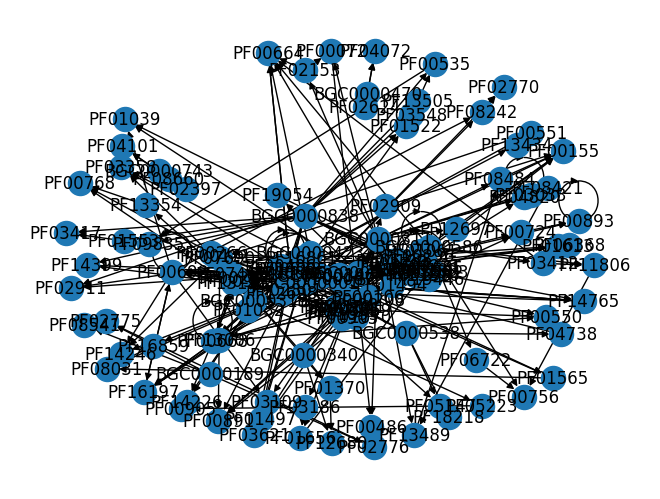

In [97]:
import networkx as nx
import pandas as pd
import math

import torch

df = pd.read_csv('genome_info.csv')
df_attributes = pd.read_csv('chemact.csv')

evalue_threshold = 1e-15

G = nx.DiGraph()  # 修改为有向图

# 创建节点和边
for _, row in df.iterrows():
    if row['Pfam_evalue'] < evalue_threshold:
        pfam_id = row['Pfam_ID']
        sequence_id = row['Sequence_ID']
        G.add_node(pfam_id, bipartite=0)  # Pfam节点

        bgc_attributes = df_attributes[df_attributes['BGC_ID'] == sequence_id].iloc[0]
        G.add_node(sequence_id, bipartite=1,  # BGC节点
                   biosyn_class=bgc_attributes['biosyn_class'],
                   if_antibacterial=bgc_attributes['if_antibacterial'],
                   if_antifungal=bgc_attributes['if_antifungal'],
                   if_cytotoxic=bgc_attributes['if_cytotoxic'])
        G.add_edge(sequence_id, pfam_id)  # 每次一个Pfam出现在一个新的BGC中时，都添加一条从BGC到Pfam的边
        # 设置目标标签
        if bgc_attributes['if_antibacterial'] == '1':
            target_label = 0  # 类别A
        else:
            target_label = 1  # 类别B
        G.nodes[sequence_id]['antibacterial'] = target_label

# 创建Pfam节点之间的边
pfam_df = df[df['Pfam_evalue'] < evalue_threshold]
for sequence_id in pfam_df['Sequence_ID'].unique():
    sequence_df = pfam_df[pfam_df['Sequence_ID'] == sequence_id].sort_values('Gene_Start')
    pfam_ids = sequence_df['Pfam_ID'].tolist()
    gene_starts = sequence_df['Gene_Start'].tolist()
    gene_strands = sequence_df['Gene_Strand'].tolist()
    for i in range(len(pfam_ids) - 1):
        # 计算权重
        weight = math.log(abs(gene_starts[i + 1] - gene_starts[i]) + 1)
        # 如果基因的方向是1，那么边的方向从i指向i+1
        if gene_strands[i] == 1:
            G.add_edge(pfam_ids[i], pfam_ids[i + 1], weight=weight)
        # 如果基因的方向是-1，那么边的方向从i+1指向i
        else:
            G.add_edge(pfam_ids[i + 1], pfam_ids[i], weight=weight)

# 输出图的信息
num_nodes = len(G.nodes)
num_edges = len(G.edges)
avg_degree = sum(dict(G.degree).values()) / num_nodes
print("Nodes:", num_nodes)
print("Edges:", num_edges)
print("Average degree:", avg_degree)

import matplotlib.pyplot as plt
nx.draw(G, with_labels=True)  # 画出图G，with_labels=True表示节点带标签
plt.show()  # 显示图形

# subgraph
bgc_subgraphs = {}
for sequence_id in df['Sequence_ID'].unique():
    # 提取出 BGC 中的 Pfam
    sequence_df = df[df['Sequence_ID'] == sequence_id]
    pfam_ids = sequence_df['Pfam_ID'].tolist()
    
    # 创建子图
    subgraph = G.subgraph(pfam_ids)
    
    # 存储子图
    bgc_subgraphs[sequence_id] = subgraph

from torch_geometric.utils import from_networkx

bgc_pyg_graphs = {}
for sequence_id, subgraph in bgc_subgraphs.items():
    # Convert the NetworkX graph to a PyTorch Geometric graph
    pyg_graph = from_networkx(subgraph)
    
    # Add node feature for each node in the graph
    pyg_graph.x = torch.ones((pyg_graph.num_nodes, 1), dtype=torch.float)

    # Assign the target value to data.y
    pyg_graph.y = torch.tensor([G.nodes[sequence_id]['antibacterial']], dtype=torch.long)

    # Store the PyTorch Geometric graph
    bgc_pyg_graphs[sequence_id] = pyg_graph



In [98]:
print(bgc_pyg_graphs)

{'BGC0000001': Data(edge_index=[2, 37], bipartite=[22], weight=[37], num_nodes=22, x=[22, 1], y=[1]), 'BGC0000189': Data(edge_index=[2, 5], bipartite=[5], weight=[5], num_nodes=5, x=[5, 1], y=[1]), 'BGC0000208': Data(edge_index=[2, 23], bipartite=[20], weight=[23], num_nodes=20, x=[20, 1], y=[1]), 'BGC0000311': Data(edge_index=[2, 44], bipartite=[25], weight=[44], num_nodes=25, x=[25, 1], y=[1]), 'BGC0000319': Data(edge_index=[2, 26], bipartite=[17], weight=[26], num_nodes=17, x=[17, 1], y=[1]), 'BGC0000340': Data(edge_index=[2, 6], bipartite=[5], weight=[6], num_nodes=5, x=[5, 1], y=[1]), 'BGC0000346': Data(edge_index=[2, 33], bipartite=[15], weight=[33], num_nodes=15, x=[15, 1], y=[1]), 'BGC0000423': Data(edge_index=[2, 22], bipartite=[12], weight=[22], num_nodes=12, x=[12, 1], y=[1]), 'BGC0000429': Data(edge_index=[2, 53], bipartite=[26], weight=[53], num_nodes=26, x=[26, 1], y=[1]), 'BGC0000470': Data(edge_index=[2, 1], bipartite=[3], weight=[1], num_nodes=3, x=[3, 1], y=[1]), 'BGC

Define the GAT model

In [106]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class GATNet(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(num_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=True, dropout=0.6)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Change the activation function to improve performance. I used elu first.
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        # Use global mean pooling to get one output for each graph
        x = global_mean_pool(x, batch)

        return F.log_softmax(x, dim=1)


Convert the graphs to PyTorch Geometric datasets

We need to convert the dictionary of PyTorch Geometric graphs into a Dataset object. This will make it easier to split the data into training and test sets, and to create data loaders.

In [107]:
from torch_geometric.data import Dataset, Data

class BGCDataset(Dataset):
    def __init__(self, bgc_pyg_graphs, transform=None, pre_transform=None):
        super(BGCDataset, self).__init__('.', transform, pre_transform)
        self.bgc_pyg_graphs = bgc_pyg_graphs

    @property
    def raw_file_names(self):
        return []  # This dataset has no raw files

    @property
    def processed_file_names(self):
        return []  # This dataset has no processed files

    def len(self):
        return len(self.bgc_pyg_graphs)

    def get(self, idx):
        # `Data` objects are stored in the `bgc_pyg_graphs` dictionary
        sequence_id = list(self.bgc_pyg_graphs.keys())[idx]
        return self.bgc_pyg_graphs[sequence_id]

dataset = BGCDataset(bgc_pyg_graphs)

Create data loaders

We'll use the random_split function to split the dataset into training and test sets, and the DataLoader class to create data loaders for these sets.

In [101]:
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from torch_geometric.data import Batch

# Split the dataset into 80% training and 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
define_batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=define_batch_size, shuffle=True, follow_batch=['x'], collate_fn=Batch.from_data_list)
test_loader = DataLoader(test_dataset, batch_size=define_batch_size, follow_batch=['x'], collate_fn=Batch.from_data_list)



Train and evaluate the model using k-fold cross-validation

We'll use the KFold class from scikit-learn to generate the training and test indices for each fold.

In [102]:
from sklearn.model_selection import KFold

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model and optimizer
model = GATNet(num_features=1, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Define the loss function
criterion = torch.nn.NLLLoss()

# Define the k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Start the k-fold cross-validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=define_batch_size, sampler=train_subsampler, collate_fn=Batch.from_data_list)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=define_batch_size, sampler=test_subsampler, collate_fn=Batch.from_data_list)

    # Init the neural network
    network = GATNet(num_features=1, num_classes=2).to(device)
    network.train()

    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=0.01)

    # Run the training loop for defined number of epochs
    for epoch in range(100):

        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):

            # Get inputs
            inputs = data.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = network(inputs)

            # Compute loss
            loss = criterion(outputs, inputs.y)

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            current_loss += loss.item()
            if i % 500 == 499:
                print('Loss after mini-batch %5d: %.3f' %
                      (i + 1, current_loss / 500))
                current_loss = 0.0

    # Process is complete.
    print('Training process has finished.')


FOLD 0
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 